In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

import torchvision
import torchvision.transforms as tr
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from tqdm import tqdm

import imageio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import copy
import urllib.request

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/models/torch_basic_study"

# Unsupervised Learning

## Generative Adversarial Networl

In [ ]:
from torchvision.datasets import FashionMNIST

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
trainset = FashionMNIST(root="./data/", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}...")

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Using cuda...


Linear Version

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.n_features = 128
    self.n_out = 784
    self.linear = nn.Sequential(
        nn.Linear(self.n_features, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, self.n_out),
        nn.Tanh())
  
  def forward(self, x):
    x = self.linear(x)
    x = x.view(-1, 1, 28, 28)
    return x

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.n_in = 784
    self.n_out = 1
    self.linear = nn.Sequential(
        nn.Linear(self.n_in, 1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(256, self.n_out),
        nn.Sigmoid())

  def forward(self, x):
    x = x.view(-1, 784)
    x = self.linear(x)
    return x

Convolution Version

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.n_features = 128
    self.conv = nn.Sequential(
        nn.ConvTranspose2d(self.n_features, 256, 3, 1, bias=True), nn.ReLU(True),
        nn.ConvTranspose2d(256, 128, 3, 2, bias=True), nn.ReLU(True),
        nn.ConvTranspose2d(128, 64, 3, 2, bias=True), nn.ReLU(True),
        nn.ConvTranspose2d(64, 1, 2, 2, 1, bias=True), nn.Tanh())
  
  def forward(self, x):
    x = x.view(-1, self.n_features, 1, 1)
    x = self.conv(x)
    return x

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(1, 128, 3, 2, 1, bias=True), nn.LeakyReLU(0.2),
        nn.Conv2d(128, 256, 3, 2, 1, bias=True), nn.LeakyReLU(0.2),
        nn.Conv2d(256, 256, 3, 2, 1, bias=True), nn.LeakyReLU(0.2),
        nn.Conv2d(256, 1, 3, 2, bias=True), nn.Sigmoid())

  def forward(self, x):
    x = self.conv(x)
    x = x.view(-1, 1)
    return x

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)
g_losses = []
d_losses = []
images = []
criterion = nn.BCELoss()

In [ ]:
def noise(n, n_features=128):
  data = torch.randn(n, n_features)
  return data.to(device)

def label_ones(size):
  data = torch.ones(size, 1)
  return data.to(device)

def label_zeros(size):
  data = torch.zeros(size, 1)
  return data.to(device)

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
  n = real_data.size(0)
  optimizer.zero_grad()
  prediction_real = discriminator(real_data)
  d_loss = criterion(prediction_real, label_ones(n))
  prediction_fake = discriminator(fake_data)
  g_loss = criterion(prediction_fake, label_zeros(n))
  loss = d_loss + g_loss
  loss.backward()
  optimizer.step()
  return loss.item()

def train_generator(optimizer, fake_data):
  n = fake_data.size(0)
  optimizer.zero_grad()
  prediction = discriminator(fake_data)
  loss = criterion(prediction, label_ones(n))
  loss.backward()
  optimizer.step()
  return loss.item()

In [ ]:
test_noise = noise(64)
l = len(trainloader)
for epoch in range(151):
  g_loss = 0.0
  d_loss = 0.0
  for data in trainloader:
    imgs, _ = data
    n = len(imgs)
    fake_data = generator(noise(n)).detach()
    real_data = imgs.to(device)
    d_loss += train_discriminator(d_optim, real_data, fake_data)
    fake_data = generator(noise(n))
    g_loss += train_generator(g_optim, fake_data)

  img = generator(test_noise).detach().cpu()
  img = make_grid(img)
  images.append(img)
  g_losses.append(g_loss/l)
  d_losses.append(d_loss/l)
  if epoch % 10 == 0:
    print(f"Epoch {epoch}: g_loss:{g_loss/l} d_loss:{d_loss/l}")

Epoch 0: g_loss:7.943456185559432 d_loss:0.055685283230101655
Epoch 10: g_loss:4.948457410732905 d_loss:0.19725938915275038
Epoch 20: g_loss:3.50902020017306 d_loss:0.3860239720592896
Epoch 30: g_loss:2.902596804499626 d_loss:0.4761539975802104
Epoch 40: g_loss:2.729328035314878 d_loss:0.5194540014863014
Epoch 50: g_loss:2.6966995127995808 d_loss:0.5193100975950559
Epoch 60: g_loss:2.702931057016055 d_loss:0.5142606012026469


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/models/torch_basic_study"
GENERATOR_SAVE_PATH = f"{MODEL_SAVE_PATH}/generator.pt"
DISCRIMINATOR_SAVE_PATH = f"{MODEL_SAVE_PATH}/discriminator.pt"
torch.save(generator.state_dict(), GENERATOR_SAVE_PATH)
torch.save(discriminator.state_dict(), DISCRIMINATOR_SAVE_PATH)

In [ ]:
to_image = transforms.ToPILImage()
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave("fasion_items.gif", imgs)

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(["Generator", "Discriminator"])
plt.title("Loss")
plt.savefig("gan_loss.png")

## Image Style Transfer

In [ ]:
STYLE_IMAGE_URL = "https://www.artinsight.co.kr/data/tmp/1912/20191210235617_eostfpur.jpg"
CONTENT_IMAGE_URL = "https://img.insight.co.kr/static/2019/04/10/700/m32ewfrrf7y6b20047xb.jpg"

urllib.request.urlretrieve(STYLE_IMAGE_URL, "/content/style_image.jpg")
urllib.request.urlretrieve(CONTENT_IMAGE_URL, "/content/content_image.jpg")

('/content/content_image.jpg', <http.client.HTTPMessage at 0x7f2d4f6a2b10>)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
def gram_matrix(input):
  a,b,c,d = input.size()
  features = input.view(a*b, c*d)
  G = torch.mm(features, features.t())
  return G.div(a*b*c*d)

In [ ]:
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()
  
  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    self.mean = mean.view(-1, 1, 1)
    self.std = std.view(-1, 1, 1)
  
  def forward(self, img):
    return (img - self.mean) / self.std

In [ ]:
def get_style_model_and_losses(cnn, style_img, content_img):
  content_layers = ["conv_4"]
  style_layers = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5"]
  normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
  normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
  normalization = Normalization(normalization_mean, normalization_std).to(device)
  content_losses = []
  style_losses = []
  model = nn.Sequential(normalization)
  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = f"conv_{i}"
    elif isinstance(layer, nn.ReLU):
      name = f"relu_{i}"
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = f"maxpool_{i}"
    elif isinstance(layer, nn.BatchNorm2d):
      name = f"bn_{i}"
    else:
      raise RuntimeError(f"Unrecognized layer : {layer.__class__.__name__}")

    model.add_module(name, layer)
    if name in content_layers:
      target = model(content_img)
      content_loss = ContentLoss(target)
      model.add_module(f"content_loss_{i}", content_loss)
      content_losses.append(content_loss)
    if name in style_layers:
      target_feature = model(style_img)
      style_loss = StyleLoss(target_feature)
      model.add_module(f"style_loss_{i}", style_loss)
      style_losses.append(style_loss)

  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
  model = model[:(i+1)]
  return model, style_losses, content_losses  

In [ ]:
def run_style_transfer(cnn, content_img, style_img, num_steps=400, style_weight=100000, content_weight=1):
  input_img = content_img.clone().detach().requires_grad_(True)
  model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img)
  optimizer = optim.LBFGS([input_img])
  iteration = [0]
  while iteration[0] <= num_steps:
    def closure():
      input_img.data.clamp_(0, 1)
      optimizer.zero_grad()
      model(input_img)
      style_score = 0
      content_score = 0
      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss
      loss = style_weight*style_score + content_weight*content_score
      loss.backward()
      iteration[0] += 1
      if iteration[0] % 50 == 0:
        print(f"Iteration {iteration[0]}: Style Loss : {style_score.item()} Content Loss : {content_score.item()}")
      return style_score + content_score
    optimizer.step(closure)
  return input_img.data.clamp(0, 1)

In [ ]:
def image_loader(img_path):
  loader = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
  image = Image.open(img_path).convert("RGB")
  image = loader(image).unsqueeze(0)
  return image.to(device)

STYLE_IMAGE_PATH = "/content/style_image.jpg"
CONTENT_IMAGE_PATH = "/content/content_image.jpg"
style_img = image_loader(STYLE_IMAGE_PATH)
content_img = image_loader(CONTENT_IMAGE_PATH)

In [ ]:
output = run_style_transfer(cnn, content_img, style_img, num_steps=300)

Iteration 50: Style Loss : 0.00030348089057952166 Content Loss : 34.99315643310547
Iteration 100: Style Loss : 8.971006900537759e-05 Content Loss : 25.032758712768555
Iteration 150: Style Loss : 3.5414050216786563e-05 Content Loss : 19.65741729736328
Iteration 200: Style Loss : 2.4822778868838213e-05 Content Loss : 16.634628295898438
Iteration 250: Style Loss : 2.206280805694405e-05 Content Loss : 15.236971855163574
Iteration 300: Style Loss : 1.9387214706512168e-05 Content Loss : 14.687284469604492


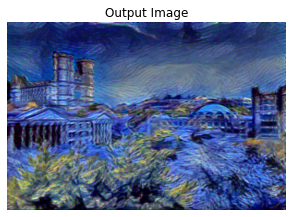

False

In [ ]:
def imshow(image, origin_size, title):
  unloader = transforms.Compose([transforms.Resize(origin_size), transforms.ToPILImage()])
  image = unloader(image.squeeze(0).cpu())
  plt.figure(figsize=(5,5))
  plt.imshow(image)
  plt.title(title)
  plt.axis("off")
  plt.show()
origin_image = cv2.imread("/content/content_image.jpg")
imshow(output, origin_image.shape[:2], title="Output Image")

## Deep K-Means Algorithm

In [ ]:
from scipy.optimize import linear_sum_assignment as linear_assignment

In [ ]:
batch_size = 128
num_clusters = 10
latent_size = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
trainset = torchvision.datasets.MNIST("./data/", download=True, train=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST("./data/", download=True, train=False, transform=transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
class Flatten(nn.Module):
  def forward(self, x):
    batch_size = x.shape[0]
    return x.view(batch_size, -1)

class Deflatten(nn.Module):
  def __init__(self, k):
    super(Deflatten, self).__init__()
    self.k = k
  
  def forward(self, x):
    s = x.size()
    feature_size = int((s[1]//self.k)**.5)
    return x.view(s[0], self.k, feature_size, feature_size)
  
class Kmeans(nn.Module):
  def __init__(self, num_clusters, latent_size):
    super(Kmeans, self).__init__()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.num_clusters = num_clusters
    self.centroids = nn.Parameter(torch.rand((self.num_clusters, latent_size)).to(device))

  def argminl2distance(self, a, b):
    return torch.argmin(torch.sum((a-b)**2, dim=1), dim=0)

  def forward(self, x):
    y_assign = []
    for m in range(x.size(0)):
      h = x[m].expand(self.num_clusters, -1)
      assign = self.argminl2distance(h, self.centroids)
      y_assign.append(assign.item())
    return y_assign, self.centroids[y_assign]

class Encoder(nn.Module):
  def __init__(self, latent_size):
    super(Encoder, self).__init__()
    k = 16
    self.encoder = nn.Sequential(
        nn.Conv2d(1, k, 3, stride=2), nn.ReLU(),
        nn.Conv2d(k, 2*k, 3, stride=2), nn.ReLU(),
        nn.Conv2d(2*k, 4*k, 3, stride=1), nn.ReLU(),
        Flatten(),
        nn.Linear(1024, latent_size), nn.ReLU())
  
  def forward(self, x):
    return self.encoder(x)

class Decoder(nn.Module):
  def __init__(self, latent_size):
    super(Decoder, self).__init__()
    k = 16
    self.decoder = nn.Sequential(
        nn.Linear(latent_size, 1024), nn.ReLU(),
        Deflatten(4*k),
        nn.ConvTranspose2d(4*k, 2*k, 3, stride=1), nn.ReLU(),
        nn.ConvTranspose2d(2*k, k, 3, stride=2), nn.ReLU(),
        nn.ConvTranspose2d(k, 1, 3, stride=2, output_padding=1), nn.Sigmoid())
  
  def forward(self, x):
    return self.decoder(x)

In [ ]:
def cluster_acc(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  D = max(y_pred.max(), y_true.max()) + 1
  w = np.zeros((D, D), dtype=np.int64)
  for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
  ind = linear_assignment(w.max() - w)
  return sum([w[i, j] for i, j in zip(ind[0], ind[1])]) * 1.0 / y_pred.size

In [ ]:
def evaluation(testloader, encoder, kmeans, device):
  predictions = []
  actual = []

  with torch.no_grad():
    for images, labels in testloader:
      inputs = images.to(device)
      labels = labels.to(device)
      latent_var = encoder(inputs)
      y_pred, _ = kmeans(latent_var)

      predictions += y_pred
      actual += labels.cpu().tolist()
  
  return cluster_acc(actual, predictions)

In [ ]:
encoder = Encoder(latent_size).to(device)
decoder = Decoder(latent_size).to(device)
kmeans = Kmeans(num_clusters, latent_size).to(device)
criterion1 = torch.nn.MSELoss()
criterion2 = torch.nn.MSELoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(kmeans.parameters()), lr=1e-3)

In [ ]:
T1 = 50
T2 = 200
lam = 1e-3
ls = 0.05
MODEL_SAVE_PATH = "/content/drive/MyDrive/models/torch_basic_study"

In [ ]:
for ep in range(300):
  if (ep > T1) and (ep < T2):
    alpha = lam * (ep - T1) / (T2 - T1)
  elif ep >= T2:
    alpha = lam
  else:
    alpha = lam/(T2 - T1)
  
  running_loss = 0.0
  for images, _ in trainloader:
    inputs = images.to(device)
    optimizer.zero_grad()
    latent_var = encoder(inputs)
    _, centroids = kmeans(latent_var.detach())
    outputs = decoder(latent_var)

    l_rec = criterion1(inputs, outputs)
    l_clt = criterion2(latent_var, centroids)
    loss = l_rec + alpha * l_clt
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  
  avg_loss = running_loss / len(trainloader)

  if ep % 10 == 0:
    testacc = evaluation(testloader, encoder, kmeans, device)
    print("[%d] Train loss: %.4f, Test Accuracy: %.3f" % (ep, avg_loss, testacc))

  if avg_loss < ls:
    ls = avg_loss
    torch.save(encoder.state_dict(), f"{MODEL_SAVE_PATH}/dkm_encoder.pt")
    torch.save(decoder.state_dict(), f"{MODEL_SAVE_PATH}/dkm_decoder.pt")
    torch.save(kmeans.state_dict(), f"{MODEL_SAVE_PATH}/dkm_kmeans.pt")

[0] Train loss: 0.0847, Test Accuracy: 0.114
[10] Train loss: 0.0273, Test Accuracy: 0.201
[20] Train loss: 0.0248, Test Accuracy: 0.374
[30] Train loss: 0.0238, Test Accuracy: 0.552
[40] Train loss: 0.0232, Test Accuracy: 0.603
[50] Train loss: 0.0227, Test Accuracy: 0.652
[60] Train loss: 0.0225, Test Accuracy: 0.679


KeyboardInterrupt: ignored

In [ ]:
encoder.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/dkm_encoder.pt"))
decoder.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/dkm_decoder.pt"))
kmeans.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/dkm_kmeans.pt"))

predictions = []
actual = []
latent_features = []
with torch.no_grad():
  for images, labels in testloader:
    inputs = images.to(device)
    labels = labels.to(device)
    latent_var = encoder(inputs)
    y_pred, _ = kmeans(latent_var)

    predictions += y_pred
    latent_features += latent_var.cpu().tolist()
    actual += labels.cpu().tolist()
print(cluster_acc(actual, predictions))

0.6864
